## GO term enrichment analysis for CLIP and ribosome profiling (Fig 5A)



## Gene ID별 좌표, GO df 준비

* transcript count table 중 발현이 낮은 값 제거한 뒤 좌표(clip, rden) 값을 계산함.
* GO는 Biomart에서 .tsv로 받았음. (6/6/24 기준 빌드 버전 GRCm39)
* 버전 제거 Gene ID를 기준으로 좌표와 GO를 합친 merged df을 생성함.

In [1]:
!conda activate rorgt
%pip install pandas numpy scipy statsmodels matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
%cd ..
%cd 2024-term-project_work

c:\Users\naeyo\Documents
c:\Users\naeyo\Documents\2024-term-project_work


In [4]:
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

print(cnts.shape)
cnts.head()

(55359, 13)


,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,CLIP-let7g.bam,filtered-RPF-siLuc.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam
Geneid,,,,,,,,,,,,,
ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,4,0,0,1,1,1,0,0
ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,3,0,0,0,0,0,0,0
ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0


In [69]:
# Count가 낮은 gene 정리
fcnts = cnts[(cnts['CLIP-35L33G.bam'] > 0) &
             (cnts['RNA-control.bam'] > 30) &
             (cnts['RPF-siLin28a.bam'] > 0) &
             (cnts['RNA-siLin28a.bam'] > 0) &
             (cnts['RPF-siLuc.bam'] > 0) &
             (cnts['RNA-siLuc.bam'] > 80)].copy()

# Calculate TPM values
def calculate_tpm(df, column, length_col='Length'):
    rpk = df[column] / (df[length_col] / 1000)  # Reads per kilobase
    scaling_factor = rpk.sum() / 1e6  # Scaling factor
    tpm = rpk / scaling_factor  # TPM
    return tpm

fcnts['TPM_CLIP-35L33G'] = calculate_tpm(fcnts, 'CLIP-35L33G.bam')
fcnts['TPM_RNA-control'] = calculate_tpm(fcnts, 'RNA-control.bam')
fcnts['TPM_RPF-siLin28a'] = calculate_tpm(fcnts, 'RPF-siLin28a.bam')
fcnts['TPM_RNA-siLin28a'] = calculate_tpm(fcnts, 'RNA-siLin28a.bam')
fcnts['TPM_RPF-siLuc'] = calculate_tpm(fcnts, 'RPF-siLuc.bam')
fcnts['TPM_RNA-siLuc'] = calculate_tpm(fcnts, 'RNA-siLuc.bam')

# Perform log transformation on TPM values
fcnts['log_TPM_CLIP'] = np.log2(fcnts['TPM_CLIP-35L33G'] )
fcnts['log_TPM_RNA_ctrl'] = np.log2(fcnts['TPM_RNA-control'] )
fcnts['log_TPM_RPF_Lin'] = np.log2(fcnts['TPM_RPF-siLin28a'] )
fcnts['log_TPM_RNA_Lin'] = np.log2(fcnts['TPM_RNA-siLin28a'] )
fcnts['log_TPM_RPF_Luc'] = np.log2(fcnts['TPM_RPF-siLuc'] )
fcnts['log_TPM_RNA_Luc'] = np.log2(fcnts['TPM_RNA-siLuc'] )

# Fold change calculations
fcnts['clip_enrichment'] = fcnts['log_TPM_CLIP'] - fcnts['log_TPM_RNA_ctrl']
fcnts['rden_change'] = (fcnts['log_TPM_RPF_Lin'] - fcnts['log_TPM_RNA_Lin']) - (fcnts['log_TPM_RPF_Luc'] - fcnts['log_TPM_RNA_Luc'])

# Index를 해제한 후 버전 제거한 gene ID column 추가
fcnts.reset_index(inplace=True)
fcnts['Gene stable ID'] = fcnts['Geneid'].str.split('.').str.get(0)

# Fold change 데이터프레임 생성
gene_change = fcnts[['Gene stable ID', 'clip_enrichment', 'rden_change']]

print(gene_change.shape)
print(gene_change.drop_duplicates().shape)
gene_change.head()

(9519, 3)
(9519, 3)


,Gene stable ID,clip_enrichment,rden_change
0,ENSMUSG00000102343,-0.311197,-0.839330
1,ENSMUSG00000103922,-0.477246,-0.172267
2,ENSMUSG00000033845,0.143658,-0.457616
3,ENSMUSG00000025903,0.409888,0.164480
4,ENSMUSG00000033813,-0.301509,-0.270258


In [70]:
# GO from Ensembl Biomart
gene_go = pd.read_csv('GO_mart_GRCm39.tsv', sep='\t').dropna()

print(gene_go.shape)
gene_go.head()

(373180, 4)


,Gene stable ID,GO term name,GO term accession,GO domain
0,ENSMUSG00000064336,translational elongation,GO:0006414,biological_process
1,ENSMUSG00000064336,triplet codon-amino acid adaptor activity,GO:0030533,molecular_function
2,ENSMUSG00000064336,mitochondrion,GO:0005739,cellular_component
3,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process
4,ENSMUSG00000064337,translation,GO:0006412,biological_process


In [71]:
# Gene ID를 기준으로 GO와 좌표를 inner join
gene_go_change = gene_go.merge(gene_change, on='Gene stable ID', how='inner')

print(gene_go_change.shape)
gene_go_change.head()

(179905, 6)


,Gene stable ID,GO term name,GO term accession,GO domain,clip_enrichment,rden_change
0,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process,0.401290,0.973912
1,ENSMUSG00000064337,translation,GO:0006412,biological_process,0.401290,0.973912
2,ENSMUSG00000064337,structural constituent of ribosome,GO:0003735,molecular_function,0.401290,0.973912
3,ENSMUSG00000064337,mitochondrial small ribosomal subunit,GO:0005763,cellular_component,0.401290,0.973912
4,ENSMUSG00000064339,translation,GO:0006412,biological_process,1.184039,1.250263


## GO term별 차이를 검정하기
* GO term별 clip과 rden에 대해 각각 Mann-Whitney U test를 수행함. (8분 소요)
* GO term과 Gene ID가 다대다 대응임에 주의!! Merged df을 바로 쓸 수 없음.
* Multiple testing correction을 위해 FDR Benjamini-Hochberg method를 적용함.

In [72]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
#from multiprocessing import Pool

In [73]:
# Group by 'GO term name'
go = gene_go_change.groupby('GO term name').agg(
    num_genes=('Gene stable ID', 'nunique'),
    clip_avg=('clip_enrichment', 'mean'),
    rden_avg=('rden_change', 'mean')
).reset_index()

print(go.shape)
go.head()

(14998, 4)


,GO term name,num_genes,clip_avg,rden_avg
0,'de novo' AMP biosynthetic process,7,-0.950178,-1.080747
1,'de novo' CTP biosynthetic process,2,-0.715190,-1.069463
2,'de novo' GDP-L-fucose biosynthetic process,1,-2.268580,-0.620218
3,'de novo' IMP biosynthetic process,6,-1.150856,-1.143045
4,'de novo' NAD biosynthetic process,1,-1.597119,-0.325952


In [74]:
# Precompute unique genes for each GO term
go_term_genes = gene_go.groupby('GO term name')['Gene stable ID'].apply(set).to_dict()

# Precompute change values for each gene for faster lookup
gene_clip = gene_change.set_index('Gene stable ID')['clip_enrichment'].to_dict()
gene_rden = gene_change.set_index('Gene stable ID')['rden_change'].to_dict()

# Precompute yes and no changes for all GO terms
clip_yes_no_changes = {}
rden_yes_no_changes = {}

all_genes = set(gene_change['Gene stable ID'])

for go_term, genes in go_term_genes.items():
    yes_genes = genes
    no_genes = all_genes - yes_genes

    clip_yes_no_changes[go_term] = ([gene_clip[gene] for gene in yes_genes if gene in gene_clip],
                                    [gene_clip[gene] for gene in no_genes if gene in gene_clip])

    rden_yes_no_changes[go_term] = ([gene_rden[gene] for gene in yes_genes if gene in gene_rden],
                                    [gene_rden[gene] for gene in no_genes if gene in gene_rden])

# Mann-Whitney U test
def mann_whitney_enrichment_test(yes_changes, no_changes):
    if len(yes_changes) > 1 and len(no_changes) > 1:
        _, p_value = mannwhitneyu(yes_changes, no_changes, alternative='two-sided')
    else:
        p_value = np.nan
    return p_value

# Apply the test for each GO term
clip_p_vals = []
rden_p_vals = []

for go_term in go['GO term name']:
    clip_p_vals.append(mann_whitney_enrichment_test(*clip_yes_no_changes[go_term]))
    rden_p_vals.append(mann_whitney_enrichment_test(*rden_yes_no_changes[go_term]))

# Add p-values to the DataFrame
go['clip_p_val'] = clip_p_vals
go['rden_p_val'] = rden_p_vals
#go.to_csv('go_backup.tsv', sep='\t', index=False)

In [77]:
# Drop rows with NaN p-values
#go_fdr = pd.read_csv('go_backup.tsv', sep='\t').dropna(subset=['clip_p_val', 'rden_p_val'])
go_fdr = go.dropna(subset=['clip_p_val', 'rden_p_val']).copy()

# FDR correction
clip_p_values = go_fdr['clip_p_val']
rden_p_values = go_fdr['rden_p_val']

go_fdr['clip_fdr'] = multipletests(clip_p_values, method='fdr_bh')[1]
go_fdr['rden_fdr'] = multipletests(rden_p_values, method='fdr_bh')[1]

# Filter for FDR < 0.05 for easier visualization
go_fdr = go_fdr[(go_fdr['clip_fdr'] < 0.05) & (go_fdr['rden_fdr'] < 0.05)]

# Sort and set index for easier visualization
go_fdr = go_fdr.sort_values(by='num_genes', ascending=False)
go_fdr.set_index('GO term name', drop=True, inplace=True)

print(go_fdr.shape)
go_fdr.head(20)

(119, 7)


,num_genes,clip_avg,rden_avg,clip_p_val,rden_p_val,clip_fdr,rden_fdr
GO term name,,,,,,,
cytoplasm,4254,-0.797105,-0.448689,1.754762e-28,5.515596e-117,4.413228e-25,1.849563e-113
nucleus,4027,-0.728172,-0.464039,2.466095e-07,3.530167e-125,9.923568e-05,1.775674e-121
membrane,3115,-0.304322,-0.025999,4.315961e-72,9.516594e-202,4.341856e-68,9.573694e-198
cytosol,2707,-0.816311,-0.472786,1.970662e-17,1.714737e-75,2.202762e-14,2.464323e-72
nucleoplasm,2409,-0.762145,-0.491102,1.253477e-07,1.792816e-80,5.254156e-05,3.005955e-77
plasma membrane,1686,-0.394600,-0.149139,2.055661e-19,6.579730e-26,2.954279e-16,3.008731e-23
mitochondrion,1286,-0.791914,-0.246038,4.480370e-07,1.385345e-04,1.609733e-04,4.805715e-03
DNA binding,981,-0.777496,-0.521555,4.392288e-04,1.622381e-36,3.776617e-02,1.165797e-33
endoplasmic reticulum,946,0.004715,0.126370,8.130766e-61,3.984846e-113,4.089775e-57,1.002189e-109


## Visualization
* 내가 반영한 부분:
  * GO term별로 평균 CLIP, rden (log2 scale이었음) 을 좌표로 하는 산점도를 그렸음.
  * colormap은 FDR로 나타내되, clip에 대한 FDR만 반영하였음.
  * annotation에 GO term 이름과 괄호 안에 number of genes, C와 R 옆에 clip과 rden에 대한 FDR을 기입하였음. (원본은 p-value?)
  * dpi 3000부터는 RAM 한도에 도달하여 런타임 끊기므로 시도하지 말 것.
* 원본 설명:
  * Each circle represents a **GO term**.
  * The **color intensity** indicates statistical significance of enrichment or depletion determined by **Mann-Whitney U test**.
  * The **size of the circle** corresponds to **the number of genes**.
  * The **coordinates** indicate average CLIP tag enrichment (x axis) and ribosome density change (y axis).
  * Balloons contain the **number of genes** (written in parentheses) and p values for CLIPseq (C) and ribosome footprinting (R).
  * Note that nucleosome-related terms are overestimated artificially in CLIP because of a normalization problem due to the lack of polyA tail in histone mRNAs.

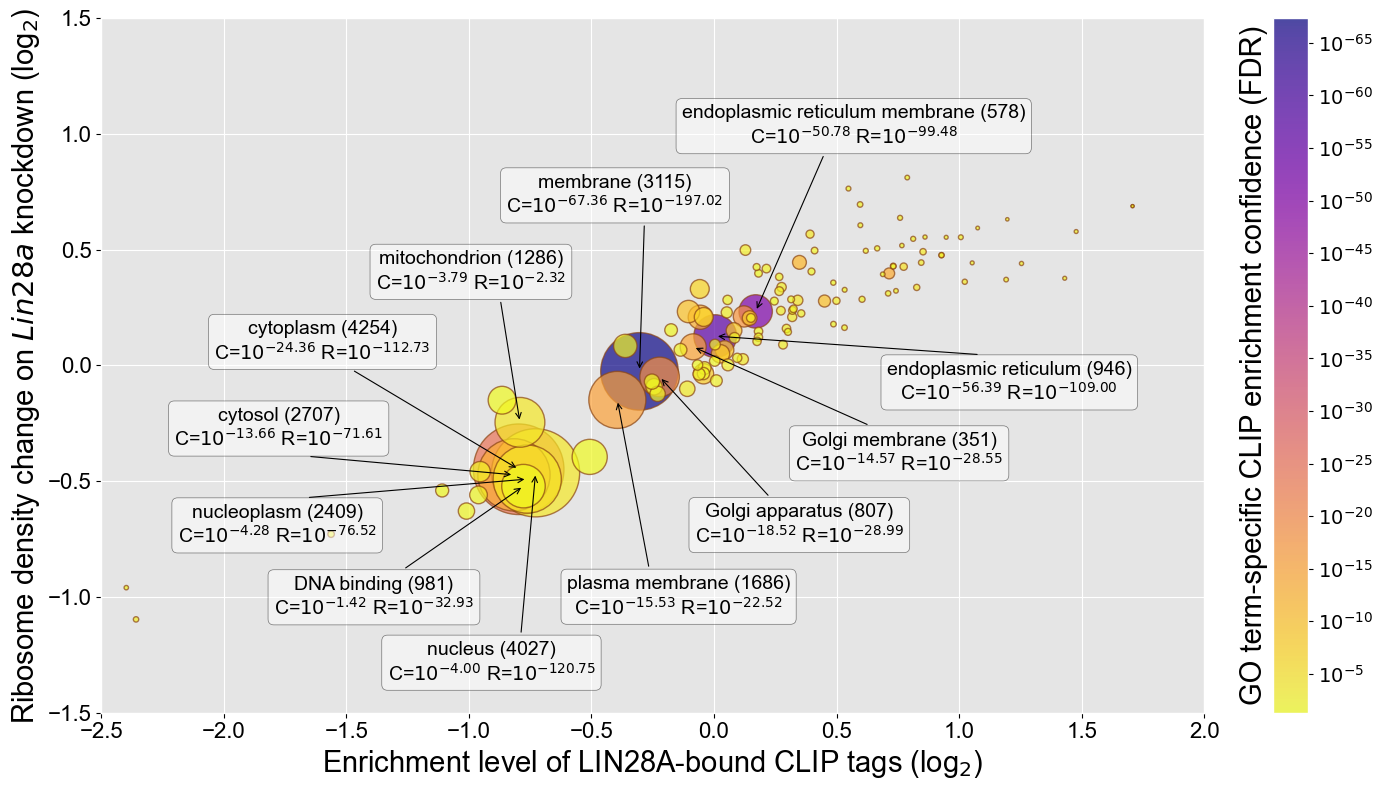

In [81]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(15, 8))

# Scatter plot
sc = plt.scatter(
    go_fdr['clip_avg'],
    go_fdr['rden_avg'],
    s=go_fdr['num_genes'] * 1,  # size
    c=np.log10(go_fdr['clip_fdr']),  # color intensity
    cmap='plasma',
    alpha=0.7,
    edgecolors='saddlebrown',
    linewidth=1
)

# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label(r'GO term-specific CLIP enrichment confidence (FDR)', fontsize=21)
cbar.ax.tick_params(labelsize=14, colors='black')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.label.set_color('black')
cbar.ax.invert_yaxis()
cbar.set_ticks(np.arange(-65, 0, 5))
cbar.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in np.arange(-65, 0, 5)])

# Set x and y axis
plt.xlim([-2.5, 2])
plt.ylim([-1.5, 1.5])
plt.xticks(np.arange(-2.5, 2.5, 0.5))
plt.yticks(np.arange(-1.5, 2, 0.5))
plt.xlabel(r'Enrichment level of LIN28A-bound CLIP tags (log$_{2}$)', fontsize=21)
plt.ylabel(r'Ribosome density change on $\it{Lin28a}$ knockdown (log$_{2}$)', fontsize=21)
#plt.title('GO term-enrichment analysis for CLIP and ribosome profiling\n', fontsize=30, fontweight='bold')

ax = plt.gca()
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.title.set_color('black')
ax.tick_params(axis='x', colors='black', labelsize=16)  # X-axis tick labels size
ax.tick_params(axis='y', colors='black', labelsize=16)  # Y-axis tick labels size

# Define function to add annotation with arrow
def add_annotation(row, text_offset=(0.2, 0.2), arrow_offset=None):
    spacing = 0.12
    arrow_offset = (text_offset[0] - spacing if text_offset[0] > 0 else text_offset[0] + spacing,
                    text_offset[1] - spacing if text_offset[1] > 0 else text_offset[1] + spacing) if arrow_offset is None else arrow_offset
    plt.text(row['clip_avg'] + text_offset[0], row['rden_avg'] + text_offset[1],
             f"{row.name} ({row['num_genes']:.0f})\nC=$10^{{{np.log10(row['clip_fdr']):.2f}}}$ R=$10^{{{np.log10(row['rden_fdr']):.2f}}}$",
             fontsize=14, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))
    plt.annotate("", xy=(row['clip_avg'], row['rden_avg']), xytext=(row['clip_avg'] + arrow_offset[0], row['rden_avg'] + arrow_offset[1]),
                 arrowprops=dict(arrowstyle="->", linewidth=0.8, color='black', alpha=1))

# Dictionary to specify text offsets for each GO term
annotation_offsets = {
    'nucleus': (-0.18, -0.82),
    'nucleoplasm': (-1.02, -0.2),
    'cytosol': (-0.96, 0.2),
    'cytoplasm': (-0.8, 0.55),
    'mitochondrion': (-0.2, 0.65),
    'plasma membrane': (0.25, -0.85),
    'membrane': (-0.1, 0.76),
    'endoplasmic reticulum': (1.2, -0.2),
    'endoplasmic reticulum membrane': (0.4, 0.8),
    'Golgi apparatus': (0.57, -0.64),
    'Golgi membrane': (0.84, -0.46),
    'DNA binding': (-0.61, -0.48),
}

# Add text annotations for each specified GO term with its offsets
for go_term, text_offset in annotation_offsets.items():
    row = go_fdr.loc[go_term]
    add_annotation(row, text_offset=text_offset)

plt.tight_layout()
plt.savefig("Figure 5A_TPM.png", format="png", dpi=2000)
plt.show()

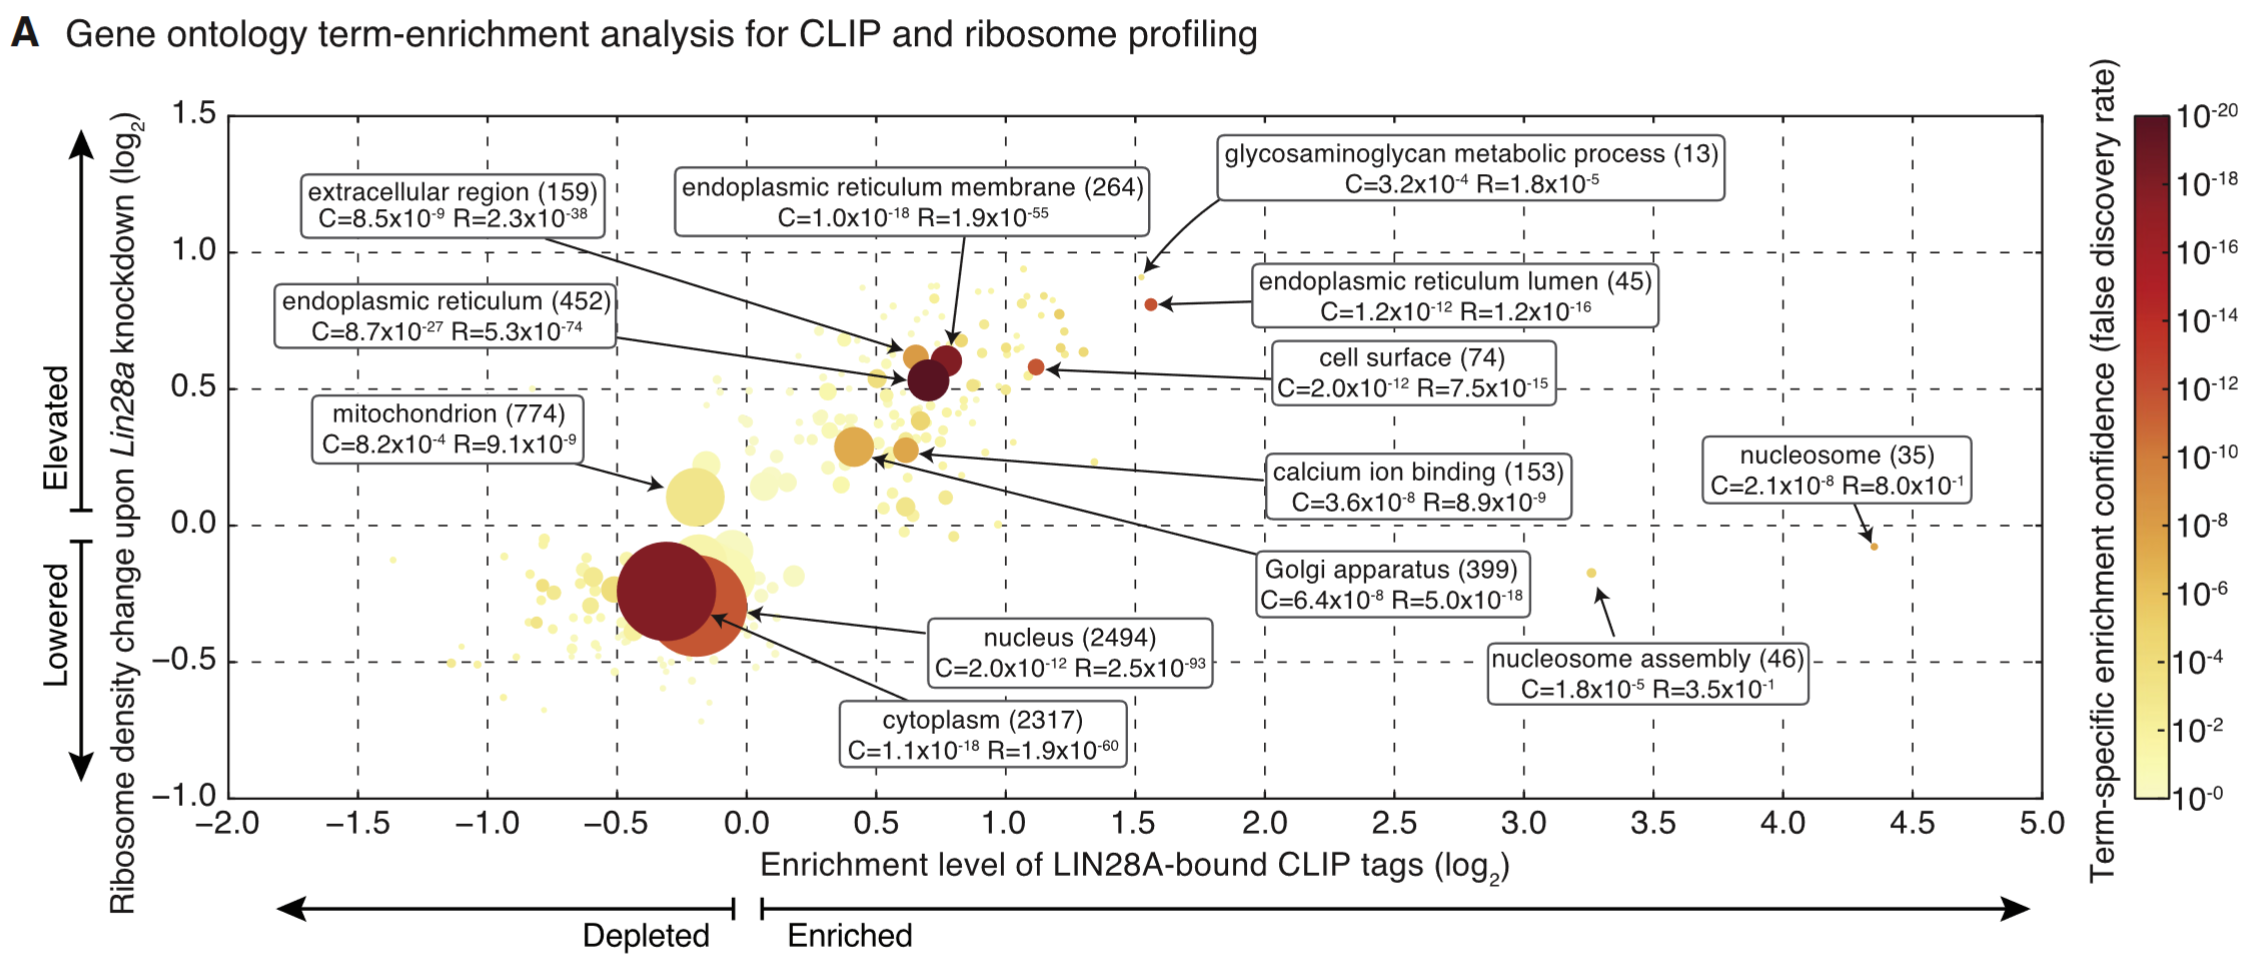

In [54]:
import matplotlib.font_manager

# Get a list of available font names
font_names = [f.name for f in matplotlib.font_manager.fontManager.ttflist]

#for font in font_names:
#    print(font)

print(font_names)
print('Helvetica' in font_names)
print('Arial' in font_names)
print('Liberation Sans' in font_names)

['STIXNonUnicode', 'cmb10', 'cmtt10', 'DejaVu Sans Display', 'DejaVu Serif', 'cmex10', 'STIXGeneral', 'cmr10', 'cmss10', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'DejaVu Serif', 'STIXSizeTwoSym', 'cmmi10', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Sans Mono', 'cmsy10', 'DejaVu Sans', 'DejaVu Serif', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXNonUnicode', 'DejaVu Sans', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXSizeFiveSym', 'STIXSizeOneSym', 'STIXGeneral', 'STIXSizeOneSym', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXSizeFourSym', 'STIXSizeThreeSym', 'DejaVu Serif Display', 'Century Gothic', 'Footlight MT Light', 'Broadway', 'Leelawadee', 'Microsoft YaHei', 'Microsoft JhengHei', 'Garamond', 'Arial', 'Times New Roman', 'Bodoni MT', 'Franklin Gothic Medium', 'Cooper Black', 'Hancom Hoonminjeongeum_V', 'Han Santteut Dotum', 'Segoe UI', 'Franklin Gothic Medium', 'Myanmar Text', 'Bell MT', 'MS Reference Sans Serif', 'Lucida Sans', 'Times New Roman', '